In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Tuple
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Set GLOBAL Variables

In [3]:
EPOCHS = 20
INIT_LR = 1e-3
batch_size = 32
seed=42
default_image_size = tuple((256, 256))
image_size = 0
directory_root = r"../input/plant-leaf-diseases-dataset-with-augmentation/Plant_leave_diseases_dataset_with_augmentation/"
img_width=160
img_height=160
depth=3
tf.random.set_seed(seed)

# Load Dataset as Generator using `tensorflow` library

In [4]:
ds = tf.keras.utils.image_dataset_from_directory(
  directory_root,
  seed=seed,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 61486 files belonging to 39 classes.


2022-06-04 07:46:25.945355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 07:46:26.064725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 07:46:26.065707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 07:46:26.071137: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Take Base Model as mobilenet_V2

In [5]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [6]:
ds_size = ds.cardinality().numpy()

# Split Dataset into `train`, `validation` and `test`

In [7]:
def split_dataset(dataset: tf.data.Dataset, 
                  dataset_size: int, 
                  train_ratio: float, 
                  validation_ratio: float) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    assert (train_ratio + validation_ratio) < 1

    train_count = int(dataset_size * train_ratio)
    validation_count = int(dataset_size * validation_ratio)
    test_count = dataset_size - (train_count + validation_count)


    train_dataset = dataset.take(train_count)
    validation_dataset = dataset.skip(train_count).take(validation_count)
    test_dataset = dataset.skip(validation_count + train_count).take(test_count)

    return train_dataset, validation_dataset, test_dataset

In [8]:
train_ds, val_ds, test_ds = split_dataset(ds, ds_size, train_ratio=0.8, validation_ratio=0.1)

In [9]:
class_names = ds.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot'

# Plot Dataset Images

2022-06-04 07:46:29.077179: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


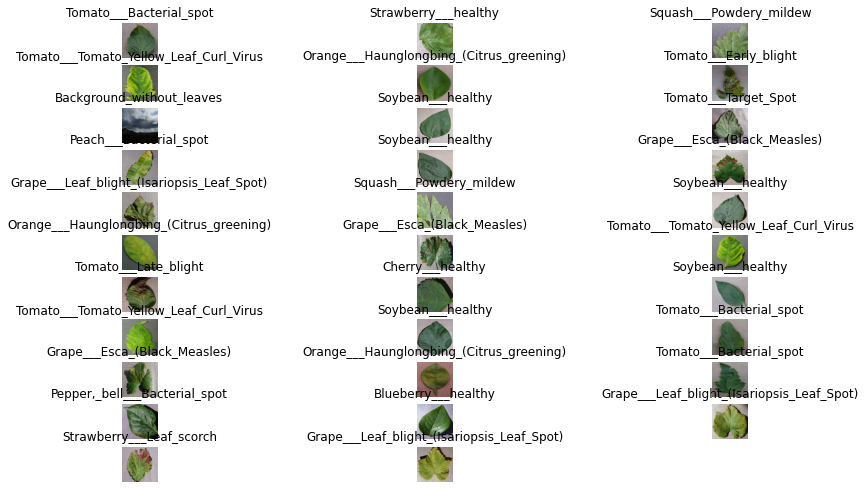

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(32):
        ax = plt.subplot(13, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Data Augumentation

In [11]:
# data_augmentation = Sequential(
#   [
#     layers.RandomFlip("horizontal",
#                       input_shape=(img_height,
#                                   img_width,
#                                   3)),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.1),
#   ]
# )

In [12]:
# early_stop_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     mode='auto')

# Compile the Base Mobilenet Model with training set to False

In [13]:
num_classes = len(class_names)

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-06-04 07:46:34.948691: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 5, 5, 1280)


In [15]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 39)


# Model Architecture with Transfer Learning

In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 39)                49959 

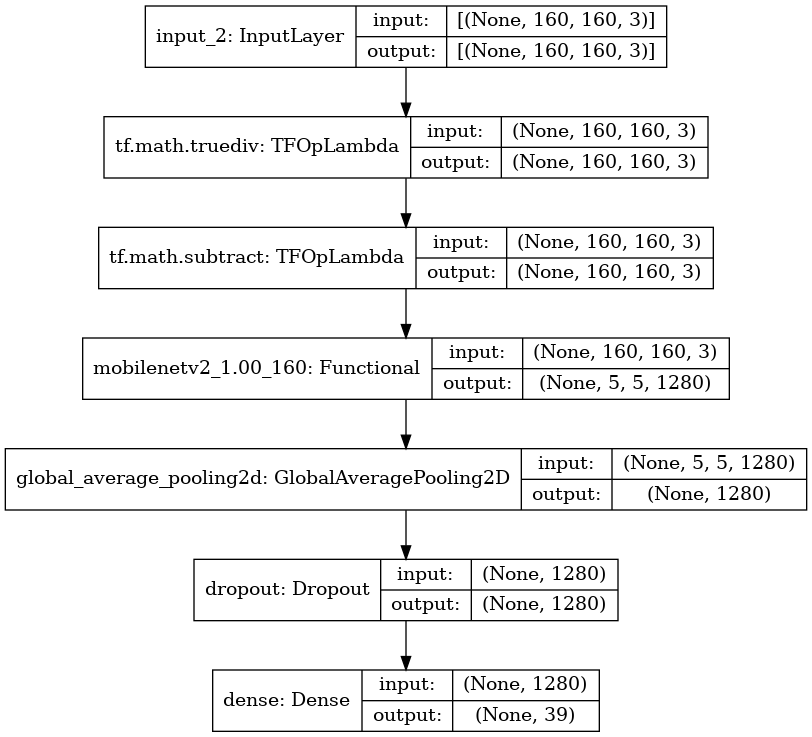

In [21]:
tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)

In [22]:
len(model.trainable_variables)

2

In [23]:
loss0, accuracy0 = model.evaluate(val_ds)

Cleanup called...


192/192 [==============================] - 150s 93ms/step - loss: 4.3386 - accuracy: 0.0326


In [24]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
#   callbacks=[early_stop_callback]
)

Epoch 1/20
1270/1537 [=======================>......] - ETA: 11s - loss: 1.5114 - accuracy: 0.6198

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 1.3608 - accuracy: 0.6577

Cleanup called...


1537/1537 [==============================] - 120s 76ms/step - loss: 1.3603 - accuracy: 0.6578 - val_loss: 0.5168 - val_accuracy: 0.8885
Epoch 2/20
1269/1537 [=======================>......] - ETA: 10s - loss: 0.4691 - accuracy: 0.8800

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.8836

Cleanup called...


1537/1537 [==============================] - 111s 72ms/step - loss: 0.4525 - accuracy: 0.8836 - val_loss: 0.3134 - val_accuracy: 0.9242
Epoch 3/20
1269/1537 [=======================>......] - ETA: 10s - loss: 0.3206 - accuracy: 0.9135

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.3135 - accuracy: 0.9153

Cleanup called...


1537/1537 [==============================] - 111s 72ms/step - loss: 0.3133 - accuracy: 0.9153 - val_loss: 0.2417 - val_accuracy: 0.9382
Epoch 4/20
1269/1537 [=======================>......] - ETA: 10s - loss: 0.2553 - accuracy: 0.9288

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.2513 - accuracy: 0.9304

Cleanup called...


1537/1537 [==============================] - 109s 71ms/step - loss: 0.2513 - accuracy: 0.9304 - val_loss: 0.2073 - val_accuracy: 0.9443
Epoch 5/20
1271/1537 [=======================>......] - ETA: 10s - loss: 0.2157 - accuracy: 0.9398

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9400

Cleanup called...


1537/1537 [==============================] - 107s 69ms/step - loss: 0.2133 - accuracy: 0.9400 - val_loss: 0.1844 - val_accuracy: 0.9469
Epoch 6/20
1270/1537 [=======================>......] - ETA: 9s - loss: 0.1888 - accuracy: 0.9467

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.9472

Cleanup called...


1537/1537 [==============================] - 103s 67ms/step - loss: 0.1873 - accuracy: 0.9472 - val_loss: 0.1654 - val_accuracy: 0.9539
Epoch 7/20
1271/1537 [=======================>......] - ETA: 9s - loss: 0.1699 - accuracy: 0.9519

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9520

Cleanup called...


1537/1537 [==============================] - 103s 67ms/step - loss: 0.1690 - accuracy: 0.9520 - val_loss: 0.1571 - val_accuracy: 0.9528
Epoch 8/20
1270/1537 [=======================>......] - ETA: 9s - loss: 0.1559 - accuracy: 0.9563

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.1554 - accuracy: 0.9563

Cleanup called...


1537/1537 [==============================] - 105s 68ms/step - loss: 0.1555 - accuracy: 0.9562 - val_loss: 0.1452 - val_accuracy: 0.9572
Epoch 9/20
1270/1537 [=======================>......] - ETA: 9s - loss: 0.1455 - accuracy: 0.9580

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9583

Cleanup called...


1537/1537 [==============================] - 103s 67ms/step - loss: 0.1444 - accuracy: 0.9583 - val_loss: 0.1373 - val_accuracy: 0.9585
Epoch 10/20
1270/1537 [=======================>......] - ETA: 9s - loss: 0.1358 - accuracy: 0.9616

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9619

Cleanup called...


1537/1537 [==============================] - 104s 68ms/step - loss: 0.1349 - accuracy: 0.9619 - val_loss: 0.1320 - val_accuracy: 0.9600
Epoch 11/20
1270/1537 [=======================>......] - ETA: 9s - loss: 0.1281 - accuracy: 0.9631

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9635

Cleanup called...


1537/1537 [==============================] - 105s 68ms/step - loss: 0.1272 - accuracy: 0.9635 - val_loss: 0.1268 - val_accuracy: 0.9621
Epoch 12/20
1270/1537 [=======================>......] - ETA: 9s - loss: 0.1195 - accuracy: 0.9656

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.1187 - accuracy: 0.9657

Cleanup called...


1537/1537 [==============================] - 102s 66ms/step - loss: 0.1187 - accuracy: 0.9657 - val_loss: 0.1232 - val_accuracy: 0.9629
Epoch 13/20
1270/1537 [=======================>......] - ETA: 9s - loss: 0.1152 - accuracy: 0.9664

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.9663

Cleanup called...


1537/1537 [==============================] - 103s 67ms/step - loss: 0.1150 - accuracy: 0.9663 - val_loss: 0.1197 - val_accuracy: 0.9637
Epoch 14/20
1268/1537 [=======================>......] - ETA: 9s - loss: 0.1114 - accuracy: 0.9677 

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9679

Cleanup called...


1537/1537 [==============================] - 109s 71ms/step - loss: 0.1105 - accuracy: 0.9679 - val_loss: 0.1164 - val_accuracy: 0.9645
Epoch 15/20
1270/1537 [=======================>......] - ETA: 9s - loss: 0.1067 - accuracy: 0.9695

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.1067 - accuracy: 0.9696

Cleanup called...


1537/1537 [==============================] - 105s 68ms/step - loss: 0.1067 - accuracy: 0.9696 - val_loss: 0.1135 - val_accuracy: 0.9653
Epoch 16/20
1271/1537 [=======================>......] - ETA: 9s - loss: 0.1033 - accuracy: 0.9695

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9696

Cleanup called...


1537/1537 [==============================] - 105s 68ms/step - loss: 0.1031 - accuracy: 0.9696 - val_loss: 0.1097 - val_accuracy: 0.9661
Epoch 17/20
1268/1537 [=======================>......] - ETA: 9s - loss: 0.0976 - accuracy: 0.9722

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.0983 - accuracy: 0.9719

Cleanup called...


1537/1537 [==============================] - 103s 67ms/step - loss: 0.0983 - accuracy: 0.9719 - val_loss: 0.1078 - val_accuracy: 0.9665
Epoch 18/20
1271/1537 [=======================>......] - ETA: 9s - loss: 0.0961 - accuracy: 0.9722

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.0966 - accuracy: 0.9722

Cleanup called...


1537/1537 [==============================] - 104s 67ms/step - loss: 0.0965 - accuracy: 0.9722 - val_loss: 0.1061 - val_accuracy: 0.9674
Epoch 19/20
1271/1537 [=======================>......] - ETA: 9s - loss: 0.0918 - accuracy: 0.9731

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9734

Cleanup called...


1537/1537 [==============================] - 109s 71ms/step - loss: 0.0917 - accuracy: 0.9734 - val_loss: 0.1064 - val_accuracy: 0.9673
Epoch 20/20
1270/1537 [=======================>......] - ETA: 10s - loss: 0.0913 - accuracy: 0.9731

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.0909 - accuracy: 0.9732

Cleanup called...


1537/1537 [==============================] - 111s 72ms/step - loss: 0.0909 - accuracy: 0.9732 - val_loss: 0.1046 - val_accuracy: 0.9676


# Plot Train and Validation Accuracy and Loss

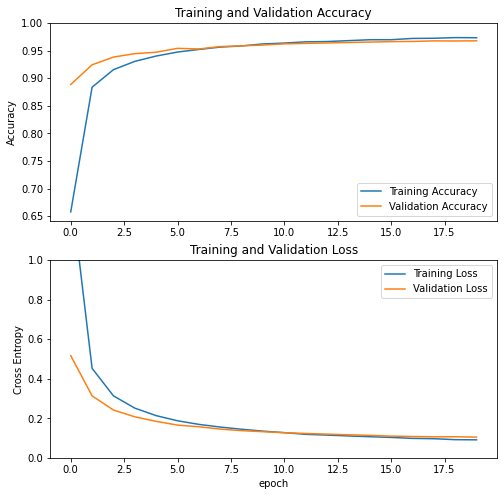

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Now fine tune the model 

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [28]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 39)                49959 

In [30]:
len(model.trainable_variables)

56

In [31]:
fine_tune_epochs = 30

history_fine = model.fit(train_ds,
                         epochs=fine_tune_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 20/30
1267/1537 [=======================>......] - ETA: 12s - loss: 0.0838 - accuracy: 0.9722

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.9728

Cleanup called...


1537/1537 [==============================] - 129s 80ms/step - loss: 0.0815 - accuracy: 0.9728 - val_loss: 0.0950 - val_accuracy: 0.9678
Epoch 21/30
1268/1537 [=======================>......] - ETA: 12s - loss: 0.0572 - accuracy: 0.9805

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9811

Cleanup called...


1537/1537 [==============================] - 125s 81ms/step - loss: 0.0557 - accuracy: 0.9811 - val_loss: 0.0609 - val_accuracy: 0.9785
Epoch 22/30
1268/1537 [=======================>......] - ETA: 12s - loss: 0.0401 - accuracy: 0.9866

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.0397 - accuracy: 0.9865

Cleanup called...


1537/1537 [==============================] - 123s 80ms/step - loss: 0.0397 - accuracy: 0.9865 - val_loss: 0.0620 - val_accuracy: 0.9787
Epoch 23/30
1268/1537 [=======================>......] - ETA: 11s - loss: 0.0294 - accuracy: 0.9901

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9902

Cleanup called...


1537/1537 [==============================] - 123s 80ms/step - loss: 0.0291 - accuracy: 0.9902 - val_loss: 0.0582 - val_accuracy: 0.9800
Epoch 24/30
1268/1537 [=======================>......] - ETA: 13s - loss: 0.0215 - accuracy: 0.9930

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9931

Cleanup called...


1537/1537 [==============================] - 133s 86ms/step - loss: 0.0211 - accuracy: 0.9931 - val_loss: 0.0553 - val_accuracy: 0.9814
Epoch 25/30
1268/1537 [=======================>......] - ETA: 12s - loss: 0.0160 - accuracy: 0.9948

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9947

Cleanup called...


1537/1537 [==============================] - 128s 83ms/step - loss: 0.0160 - accuracy: 0.9947 - val_loss: 0.0507 - val_accuracy: 0.9836
Epoch 26/30
1268/1537 [=======================>......] - ETA: 12s - loss: 0.0124 - accuracy: 0.9959

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9961

Cleanup called...


1537/1537 [==============================] - 124s 81ms/step - loss: 0.0120 - accuracy: 0.9961 - val_loss: 0.0498 - val_accuracy: 0.9844
Epoch 27/30
1268/1537 [=======================>......] - ETA: 12s - loss: 0.0103 - accuracy: 0.9967

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9967

Cleanup called...


1537/1537 [==============================] - 119s 77ms/step - loss: 0.0100 - accuracy: 0.9967 - val_loss: 0.0552 - val_accuracy: 0.9824
Epoch 28/30
1269/1537 [=======================>......] - ETA: 11s - loss: 0.0076 - accuracy: 0.9976

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9977

Cleanup called...


1537/1537 [==============================] - 117s 76ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.0416 - val_accuracy: 0.9868
Epoch 29/30
1270/1537 [=======================>......] - ETA: 11s - loss: 0.0059 - accuracy: 0.9982

Cleanup called...


1536/1537 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9982

Cleanup called...


1537/1537 [==============================] - 116s 75ms/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.0434 - val_accuracy: 0.9868
Epoch 30/30
1270/1537 [=======================>......] - ETA: 11s - loss: 0.0046 - accuracy: 0.9986

Cleanup called...


1537/1537 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9986

Cleanup called...


1537/1537 [==============================] - 120s 78ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0511 - val_accuracy: 0.9852


# Plot all losses and accuracies together

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

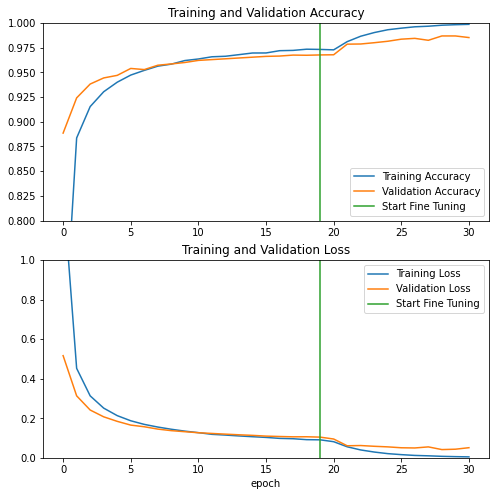

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
y_true, y_pred = [], []
for image_batch, labels in test_ds:
    predictions = model.predict_on_batch(image_batch)
    scores = tf.nn.softmax(predictions, axis=1)
    score = tf.nn.softmax(predictions[0])
    for label, score in zip(labels, scores):
        y_true.append(class_names[label])
        y_pred.append(class_names[np.argmax(score)])

Cleanup called...


In [35]:
from sklearn.metrics import classification_report

In [36]:
print(classification_report(y_true, y_pred))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.96      0.98        94
                            Apple___Black_rot       1.00      0.99      1.00       113
                     Apple___Cedar_apple_rust       1.00      0.99      0.99       100
                              Apple___healthy       0.99      1.00      0.99       148
                    Background_without_leaves       0.99      1.00      1.00       123
                          Blueberry___healthy       1.00      1.00      1.00       156
                      Cherry___Powdery_mildew       0.99      1.00      1.00       107
                             Cherry___healthy       1.00      0.99      0.99        94
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.82      0.98      0.89        87
                           Corn___Common_rust       1.00      1.00      1.00       154
                  Corn___Northern_Leaf_Bli

In [37]:
!mkdir -p saved_model

In [38]:
model.save('saved_model/my_model')

2022-06-04 09:01:03.310479: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [39]:
saved_model = tf.keras.models.load_model('./saved_model/my_model/')